### 11763 Medical Image Processing 

Amelia Yolanda / May 2024

Objective 2: 3D Rigid Coregistration
- Coregister the given images using either landmarks or a function similarity measure. Implement the image coregistration yourself (i.e. without libraries such as PyElastix).
- Visualize the Thalamus region on the input image space.

In [1]:
import os
import matplotlib
import numpy as np
import scipy
import pydicom
import pandas as pd
import glob
import cv2
import math

from matplotlib import pyplot as plt, animation
from scipy.optimize import least_squares, minimize
from scipy.ndimage import zoom, affine_transform
from skimage import exposure

In [2]:
# https://stackoverflow.com/questions/62159709/pydicom-read-file-is-only-working-with-some-dicom-images
#!pip install python-gdcm 

- Reference image: icbm avg 152 t1 tal nlin symmetric VI, of a T1 RM phantom in a normalized space.
- Input image: RM Brain 3D-SPGR, of an anonimized patient.


#### Load reference image

In [3]:
img_path = "./Project/icbm_avg_152_t1_tal_nlin_symmetric_VI.dcm"
ref_img = pydicom.dcmread(img_path)

print("Reference Image pixel_array shape: ", ref_img.pixel_array.shape)

reference_array = ref_img.pixel_array

Reference Image pixel_array shape:  (193, 229, 193)


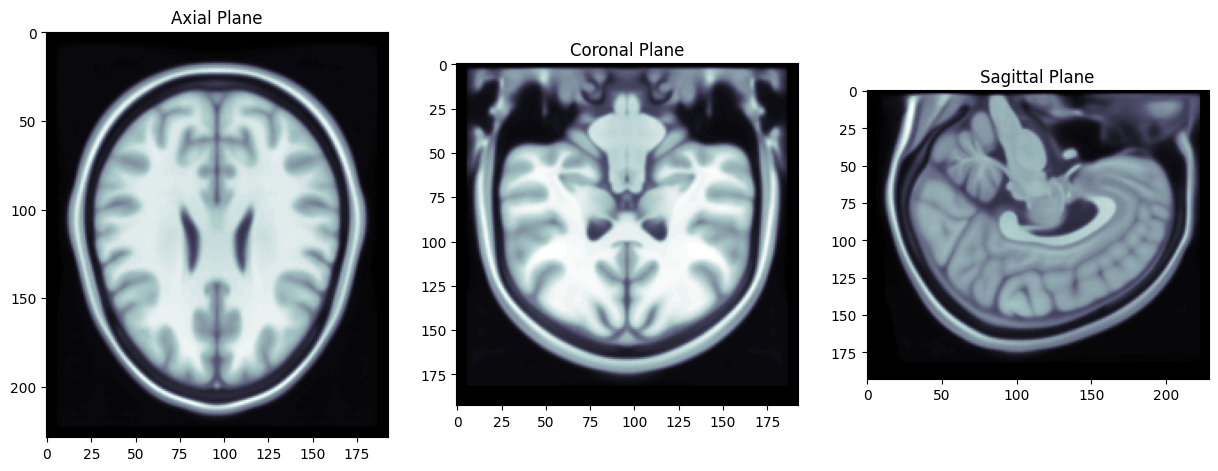

In [4]:
# Sample reference pixel_array
fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(131)
ax1.set_title("Axial Plane")
ax1.imshow(ref_img.pixel_array[100, :, :], cmap='bone')

ax2 = fig.add_subplot(132)
ax2.set_title("Coronal Plane")
ax2.imshow(ref_img.pixel_array[:, 100, :], cmap='bone')

ax3 = fig.add_subplot(133)
ax3.set_title("Sagittal Plane")
ax3.imshow(ref_img.pixel_array[:, :, 100], cmap='bone')

#### Load patient data

In [5]:
ct_path = "./Project/RM_Brain_3D-SPGR/"

def extract_ct_data(ct_path_sort): # from obj 1, please bear with the naming
    ct_data = []
    ct_metadata = []

    for file in ct_path_sort:
        if file.endswith(".dcm"):
            path = os.path.join(ct_path, file)
            dataset = pydicom.dcmread(path)  # Load DICOM file
            #ct_data.append(dataset.pixel_array)
            ct_data.append(dataset)
            
            # Extract and append DICOM metadata to list
            ct_metadata.append({
                'AcquisitionNumber': dataset.AcquisitionNumber,
                'SliceIndex': dataset.InstanceNumber,
                'ImagePositionPatient': dataset.ImagePositionPatient,
                'ReferencedSegmentNumber': dataset.SOPInstanceUID,
                'SliceLocation': dataset.SliceLocation,
                'CTFile': file
            })
    # Convert metadata list to DataFrame
    metadata_df = pd.DataFrame(ct_metadata)
    return ct_data, metadata_df

In [6]:
# Ensure dataset in correct order
ct_path_sort = sorted(os.listdir(ct_path))

ct_data, ct_metadata = extract_ct_data(ct_path_sort)
print("Amount of patient file data: ", len(ct_data))

#ct_metadata.tail()

Amount of patient file data:  212


In [7]:
merge_data = {}

for file in ct_data:
    merge_data[float(file.SliceLocation)] = file.pixel_array

sorted_merge_data = {key:merge_data[key] for key in sorted(merge_data.keys())}
array_merge_data = np.array([i for i in sorted_merge_data.values()])

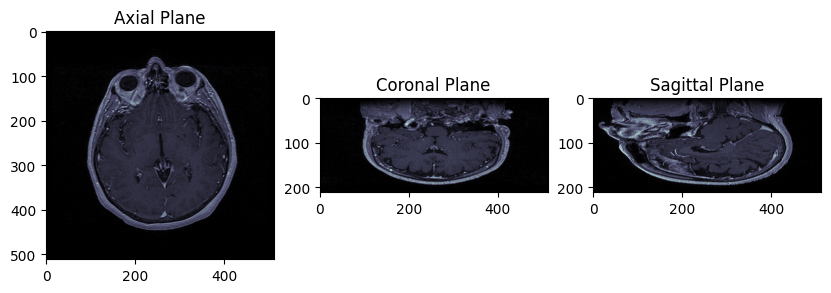

In [8]:
# Sample input patient data pixel_array
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(131)
ax1.set_title("Axial Plane")
ax1.imshow(array_merge_data[100, :, :], cmap='bone') # index from roughly half of shape

ax2 = fig.add_subplot(132)
ax2.set_title("Coronal Plane")
ax2.imshow(array_merge_data[:, 250, :], cmap='bone')

ax3 = fig.add_subplot(133)
ax3.set_title("Sagittal Plane")
ax3.imshow(array_merge_data[:, :, 250], cmap='bone')

#### Load AAL3 
(Automated Anatomical Labelling 3)

In [9]:
aal_path = "./Project/AAL3_1mm.dcm"
aal_img = pydicom.dcmread(aal_path)

print("AAL Image pixel_array shape: ", aal_img.pixel_array.shape)

aal_array = aal_img.pixel_array

AAL Image pixel_array shape:  (181, 217, 181)


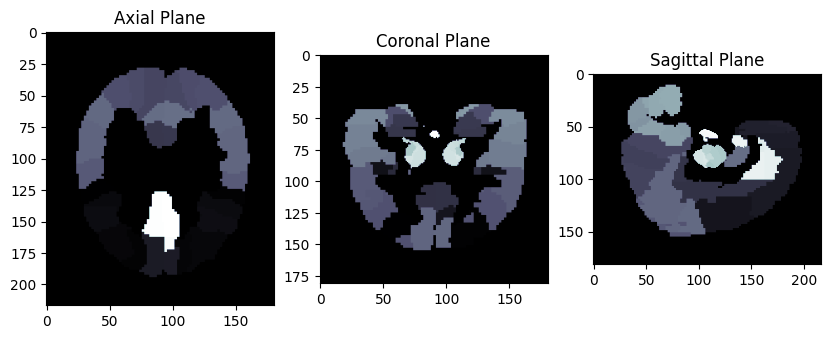

In [10]:
# Sample AAL pixel_array
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(131)
ax1.set_title("Axial Plane")
ax1.imshow(aal_img.pixel_array[100, :, :], cmap='bone')

ax2 = fig.add_subplot(132)
ax2.set_title("Coronal Plane")
ax2.imshow(aal_img.pixel_array[:, 100, :], cmap='bone')

ax3 = fig.add_subplot(133)
ax3.set_title("Sagittal Plane")
ax3.imshow(aal_img.pixel_array[:, :, 100], cmap='bone')

In [11]:
print(f"Patient data shape: {ct_data[0].pixel_array.shape}")
print(f"Reference image shape: {ref_img.pixel_array.shape}")
print(f"AAL image shape: {aal_img.pixel_array.shape}")

Patient data shape: (512, 512)
Reference image shape: (193, 229, 193)
AAL image shape: (181, 217, 181)


#### Merge reference image, input image, and AAL image

In [12]:
pixel_len_mm = [ct_data[0].SliceThickness, ct_data[0].PixelSpacing[0], ct_data[0].PixelSpacing[1]]  # Pixel length in mm [z, y, x]
pixel_len_mm

['2.0', '0.5078', '0.5078']

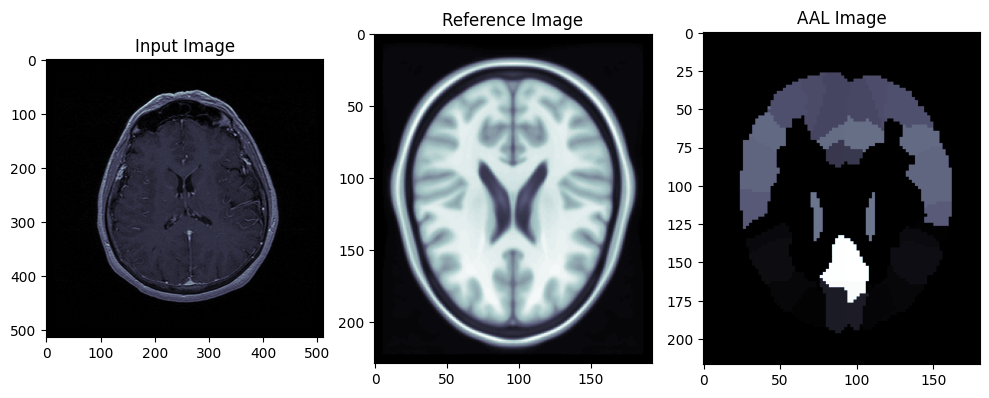

In [13]:
# Stack the input images, reference images, and segmentation masks into 3D arrays
input_volume = np.concatenate([img[np.newaxis, :] for img in array_merge_data], axis=0)
ref_volume = np.concatenate([img[np.newaxis, :] for img in reference_array], axis=0)
segmentation_volume = np.concatenate([img[np.newaxis, :] for img in aal_array], axis=0)

# Select an index for visualization
slice_index = 95 # roughly the middle plane

# Extract specific slices from each volume for visualization
input_slice = input_volume[slice_index + 20, :, :]
ref_slice = ref_volume[slice_index, :, :]
segmentation_slice = segmentation_volume[slice_index, :, :]

# Initialize a figure with three subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(10, 8))

# Define the slices and their corresponding titles
slices = [input_slice, ref_slice, segmentation_slice]
titles = ["Input Image", "Reference Image", "AAL Image"]

# Plot each slice in a subplot
for idx, (slice_img, title) in enumerate(zip(slices, titles)):
    axes[idx].imshow(slice_img, cmap='bone')
    axes[idx].set_title(title)

# Display the plots
plt.tight_layout()
plt.show()


In [14]:
def get_thalamus_mask(img_atlas: np.ndarray) -> np.ndarray:
    thalamus_mask = np.zeros_like(img_atlas)
    thalamus_mask[(121 <= img_atlas) & (img_atlas <= 150)] = 1
    return thalamus_mask

def find_centroid(mask: np.ndarray) -> np.ndarray:
    # Your code here:
    #   Consider using `np.where` to find the indices of the voxels in the mask
    #   ...
    idcs = np.where(mask == 1)
    centroid = np.stack([
        np.mean(idcs[0]),
        np.mean(idcs[1]),
        np.mean(idcs[2]),
    ])
    return centroid

def rotate_on_axial_plane(img_dcm: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    """Rotate the image on the axial plane."""
    return scipy.ndimage.rotate(img_dcm, angle_in_degrees, axes=(1, 2), reshape=False)

# from: https://github.com/realr3fo/medical_imaging

def normalize_intensity(input_image, reference_image):
    # Flatten the images to 1D arrays
    input_flat = input_image.flatten()
    reference_flat = reference_image.flatten()
    
    # Perform histogram matching
    matched_flat = exposure.match_histograms(input_flat, reference_flat)
    
    # Reshape the matched image back to its original shape
    matched_image = np.reshape(matched_flat, input_image.shape)
    return matched_image

def preprocess_landmarks(landmarks):
    max_value = np.max(landmarks)
    normalized_landmarks = landmarks / max_value
    preprocessed_landmarks = np.round(normalized_landmarks, 2) * 100
    return preprocessed_landmarks.astype(int)

In [15]:
# from: https://github.com/realr3fo/medical_imaging

# Reshape the phantom and AAL data 
img_phantom = ref_img.pixel_array[6:-6, 6:-7, 6:-6]     # Crop phantom to AAL size
aal_array = aal_array[:, :-1, :]     # Crop atlas size so that the sum of the shapes is divisible by 3

thalamus_mask = get_thalamus_mask(aal_array)
mask_centroid = find_centroid(thalamus_mask)
mask_centroid_idx = mask_centroid[0].astype('int')

# Reshape the input data (crop, zoom, and initial rotation)
input_data = array_merge_data
z_start = (input_data.shape[0] - 181) + 3 # adjust with the mask
z_end = z_start + 181
cropped_data = input_data[z_start:z_end, 48:456, 83:438]

resize_factors = (181 / cropped_data.shape[0], 216 / cropped_data.shape[1], 181 / cropped_data.shape[2])
zoom_data = zoom(cropped_data, resize_factors, order=1)
rotate_val = 180
rotated_data = rotate_on_axial_plane(zoom_data, rotate_val)
processed_input = normalize_intensity(rotated_data, img_phantom)
processed_input = preprocess_landmarks(processed_input)

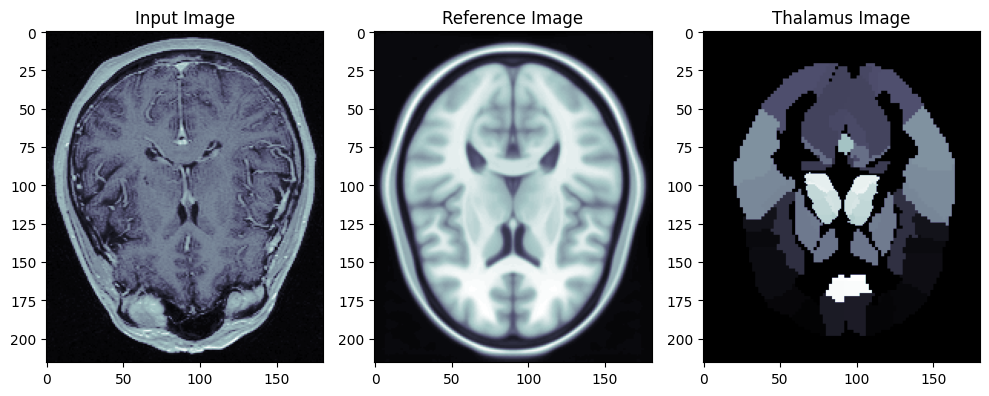

In [16]:
# Visualization after preprocessing
fig, ax = plt.subplots(1, 3, figsize=(10, 8))

images = [processed_input[mask_centroid_idx], img_phantom[mask_centroid_idx], aal_array[mask_centroid_idx]]
titles = ["Input Image", "Reference Image", "Thalamus Image"]

for i in range(3):
    ax[i].imshow(images[i], cmap='bone')
    ax[i].set_title(titles[i])

fig.tight_layout()
plt.show()


In [17]:
inp_landmarks = processed_input.reshape(-1, 3)

In [18]:
mask_centroid

array([ 78.21378526, 108.45607521,  89.9529912 ])

In [19]:
# Resample the atlas to match the DICOM dimensions
def resample_image(image: np.ndarray, target_shape: tuple) -> np.ndarray:
    factors = [
        target_shape[0] / image.shape[0],
        target_shape[1] / image.shape[1],
        target_shape[2] / image.shape[2]
    ]
    resampled_image = zoom(image, factors, order=1)
    return resampled_image

resampled_atlas = resample_image(aal_array, reference_array.shape)
resampled_mask = get_thalamus_mask(resampled_atlas)
ref_centroid_resampled = find_centroid(resampled_mask)

print(f"Resampled atlas shape: {resampled_atlas.shape}")
print(f"Resampled mask shape: {resampled_mask.shape}")
print(f"Resampled centroid reference: {ref_centroid_resampled}")



Resampled atlas shape: (193, 229, 193)
Resampled mask shape: (193, 229, 193)
Resampled centroid reference: [ 83.03089462 122.64873958  95.85381918]


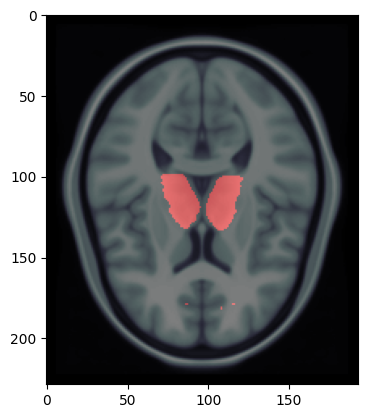

In [20]:
def visualize_axial_slice(img: np.ndarray, mask: np.ndarray, mask_centroid: np.ndarray):
    img_slice = img[int(mask_centroid[0]), :, :]
    mask_slice = mask[int(mask_centroid[0]), :, :]

    cmap = plt.get_cmap("bone")
    norm = plt.Normalize(vmin=np.amin(img_slice), vmax=np.amax(img_slice))
    fused_slice = 0.5 * cmap(norm(img_slice))[..., :3] + 0.5 * np.stack([mask_slice, np.zeros_like(mask_slice), np.zeros_like(mask_slice)], axis=-1)

    plt.imshow(fused_slice)
    plt.show()

visualize_axial_slice(reference_array, resampled_mask, ref_centroid_resampled)

In [21]:
# from activity05

def multiply_quaternions(
        q1: tuple[float, float, float, float],
        q2: tuple[float, float, float, float]
        ) -> tuple[float, float, float, float]:
    """ Multiply two quaternions, expressed as (1, i, j, k). """
    # Your code here:
    #   ...
    return (
        q1[0] * q2[0] - q1[1] * q2[1] - q1[2] * q2[2] - q1[3] * q2[3],
        q1[0] * q2[1] + q1[1] * q2[0] + q1[2] * q2[3] - q1[3] * q2[2],
        q1[0] * q2[2] - q1[1] * q2[3] + q1[2] * q2[0] + q1[3] * q2[1],
        q1[0] * q2[3] + q1[1] * q2[2] - q1[2] * q2[1] + q1[3] * q2[0]
    )

def conjugate_quaternion(
        q: tuple[float, float, float, float]
        ) -> tuple[float, float, float, float]:
    """ Multiply two quaternions, expressed as (1, i, j, k). """
    # Your code here:
    #   ...
    return (
        q[0], -q[1], -q[2], -q[3]
    )

def translation(
        point: tuple[float, float, float],
        translation_vector: tuple[float, float, float]
        ) -> tuple[float, float, float]:
    """ Perform translation of `point` by `translation_vector`. """
    x, y, z = point
    v1, v2, v3 = translation_vector
    # Your code here
    # ...
    return (x+v1, y+v2, z+v3)

def axial_rotation(
        point: tuple[float, float, float],
        angle_in_rads: float,
        axis_of_rotation: tuple[float, float, float]) -> tuple[float, float, float]:
    """ Perform axial rotation of `point` around `axis_of_rotation` by `angle_in_rads`. """
    x, y, z = point
    v1, v2, v3 = axis_of_rotation
    # Normalize axis of rotation to avoid restrictions on optimizer
    v_norm = math.sqrt(sum([coord ** 2 for coord in [v1, v2, v3]]))
    v1, v2, v3 = v1 / v_norm, v2 / v_norm, v3 / v_norm
    # Your code here:
    #   ...
    #   Quaternion associated to point.
    p = (0, x, y, z)
    #   Quaternion associated to axial rotation.
    cos, sin = math.cos(angle_in_rads / 2), math.sin(angle_in_rads / 2)
    q = (cos, sin * v1, sin * v2, sin * v3)
    #   Quaternion associated to image point
    q_star = conjugate_quaternion(q)
    p_prime = multiply_quaternions(q, multiply_quaternions(p, q_star))
    #   Interpret as 3D point (i.e. drop first coordinate)
    return p_prime[1], p_prime[2], p_prime[3]

In [22]:
# from activity06
def translation_then_axialrotation(point: tuple[float, float, float], parameters: tuple[float, ...]):
    """ Apply to `point` a translation followed by an axial rotation, both defined by `parameters`. """
    x, y, z = point
    t1, t2, t3, angle_in_rads, v1, v2, v3 = parameters
    # Normalize axis of rotation to avoid restrictions on optimizer
    v_norm = math.sqrt(sum([coord ** 2 for coord in [v1, v2, v3]]))
    v1, v2, v3 = v1/v_norm, v2/v_norm, v3/v_norm
    # Your code here:
    #   ...
    x, y, z = translation(point=(x, y, z), translation_vector=(t1, t2, t3))
    x, y, z = axial_rotation(point=(x, y, z), angle_in_rads=angle_in_rads, axis_of_rotation=(v1, v2, v3))
    return x, y, z


def screw_displacement(point: tuple[float, float, float], parameters: tuple[float, ...]):
    """ Apply to `point` the screw displacement defined by `parameters`. """
    x, y, z = point
    v1, v2, v3, angle_in_rads, displacement = parameters
    # Normalize axis of rotation to avoid restrictions on optimizer
    v_norm = math.sqrt(sum([coord ** 2 for coord in [v1, v2, v3]]))
    v1, v2, v3 = v1/v_norm, v2/v_norm, v3/v_norm
    # Your code here:
    #   ...
    x, y, z = translation(point=(x, y, z), translation_vector=(displacement*v1, displacement*v2, displacement*v3))
    x, y, z = axial_rotation(point=(x, y, z), angle_in_rads=angle_in_rads, axis_of_rotation=(v1, v2, v3))
    return x, y, z


def vector_of_residuals(ref_points: np.ndarray, inp_points: np.ndarray) -> np.ndarray:
    """ Given arrays of 3D points with shape (point_idx, 3), compute vector of residuals as their respective distance """
    # Your code here:
    #   ...
    return np.sqrt(np.sum((ref_points-inp_points)**2, axis=1))


def coregister_landmarks(ref_landmarks: np.ndarray, inp_landmarks: np.ndarray):
    """ Coregister two sets of landmarks using a rigid transformation. """
    initial_parameters = [
        0, 0, 0,    # Translation vector
        0,          # Angle in rads
        1, 0, 0,    # Axis of rotation
    ]
    # Find better initial parameters
    centroid_ref = np.mean(ref_landmarks, axis=0)
    centroid_inp = np.mean(inp_landmarks, axis=0)
    # Your code here:
    #   ...
    initial_parameters[0] = centroid_ref[0] - centroid_inp[0]
    initial_parameters[1] = centroid_ref[1] - centroid_inp[1]
    initial_parameters[2] = centroid_ref[2] - centroid_inp[2]

    def function_to_minimize(parameters):
        """ Transform input landmarks, then compare with reference landmarks."""
        # Your code here:
        #   ...
        inp_landmarks_transf = np.asarray([translation_then_axialrotation(point, parameters) for point in inp_landmarks])
        return vector_of_residuals(ref_landmarks, inp_landmarks_transf)

    # Apply least squares optimization
    result = least_squares(
        function_to_minimize,
        x0=initial_parameters,
        verbose=1)
    return result

In [23]:
# from: https://github.com/realr3fo/medical_imaging

down_sampled_ref = img_phantom[::4, ::4, ::4].reshape(-1,3)
down_sampled_inp_shape = processed_input[::4, ::4, ::4].shape
down_sampled_inp = processed_input[::4, ::4, ::4].reshape(-1,3)

ref_landmarks = img_phantom.reshape(-1, 3)
inp_landmarks = processed_input.reshape(-1, 3)

limit = inp_landmarks.shape[0]

In [24]:
result = coregister_landmarks(down_sampled_ref[:limit], down_sampled_inp[:limit])

The maximum number of function evaluations is exceeded.
Function evaluations 700, initial cost 2.1509e+07, final cost 2.1506e+07, first-order optimality 8.28e+03.


In [35]:
solution_found = result.x

t1, t2, t3, angle_in_rads, v1, v2, v3 = result.x
best_params = result.x

print('Best parameters:')
print(f'  >> Translation: ({t1:0.02f}, {t2:0.02f}, {t3:0.02f}).')
print(f'  >> Rotation: {angle_in_rads:0.02f} rads around axis ({v1:0.02f}, {v2:0.02f}, {v3:0.02f}).')


Best parameters:
  >> Translation: (-2.13, -2.17, -2.02).
  >> Rotation: -0.01 rads around axis (0.99, -0.06, 0.12).


In [39]:
best_params

array([-2.12559466, -2.17358181, -2.02317746, -0.0119211 ,  0.99094239,
       -0.06293421,  0.11874191])

In [25]:
# Define a function to compute the rigid transformation matrix
def rigid_transform_matrix(translation, rotation_angles):
    cx, cy, cz = np.cos(rotation_angles)
    sx, sy, sz = np.sin(rotation_angles)
    
    rotation_matrix = np.array([
        [cy*cz, -cy*sz, sy],
        [sx*sy*cz + cx*sz, -sx*sy*sz + cx*cz, -sx*cy],
        [-cx*sy*cz + sx*sz, cx*sy*sz + sx*cz, cx*cy]
    ])
    
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation_matrix
    transformation_matrix[:3, 3] = translation
    
    return transformation_matrix

# Example parameters for translation and rotation
translation = [10, 5, -3]  # Translation vector
rotation_angles = [0.1, 0.05, -0.02]  # Rotation angles in radians for x, y, z

# Get the rigid transformation matrix
transformation_matrix = rigid_transform_matrix(translation, rotation_angles)

# Apply the rigid transformation to the resampled mask
def apply_rigid_transform(img: np.ndarray, matrix: np.ndarray) -> np.ndarray:
    return affine_transform(img, matrix[:3, :3], offset=matrix[:3, 3])

transformed_mask = apply_rigid_transform(resampled_mask, transformation_matrix)

print(f"Transformed mask shape: {transformed_mask.shape}")


Transformed mask shape: (193, 229, 193)


In [26]:
# Transform the centroid using the transformation matrix
def transform_centroid(centroid: np.ndarray, matrix: np.ndarray) -> np.ndarray:
    centroid_homogeneous = np.append(centroid, 1)
    transformed_centroid = np.dot(matrix, centroid_homogeneous)[:3]
    return transformed_centroid

transformed_centroid = transform_centroid(ref_centroid_resampled, transformation_matrix)

print(f"Transformed centroid: {transformed_centroid}")


Transformed centroid: [100.15098289 116.22837969 100.08174071]


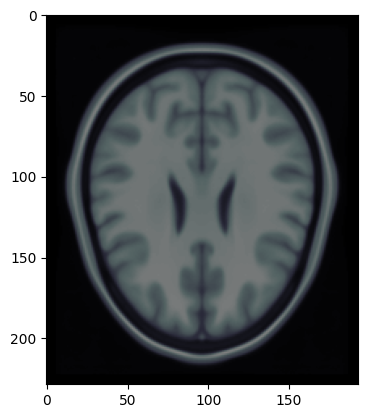

In [27]:
visualize_axial_slice(reference_array, transformed_mask, transformed_centroid)